In [1]:
import numpy as np
import pandas as pd

from src.constant import DATA_DIR, DATABASE_DIR, MAIN_DIR
from src.database import DB
from src.database.queries import *
from src.instance.InstanceList import InstanceList
from src.instance.TSP_Instance import TSP_from_index_file
from src.solver.TSP_LKH_Solver import TSP_LKH_Solver
from dataclasses import dataclass
import pathlib
pd.options.display.max_colwidth = 200
BASE_DIR = MAIN_DIR / "_archive" / "experiments" / "2025-03-05"

## loading

In [4]:
@dataclass
class CutOff:
    cost_600: float
    time_600: float
    cost_400: float
    time_400: float
    cost_200: float
    time_200: float
    label: str

    @property
    def dir(self):
        return BASE_DIR / self.label


cut_offs = [
    CutOff(
        cost_600=100.0,
        time_600=10.0,
        cost_400=41.0,
        time_400=4.1,
        cost_200=8.9,
        time_200=0.89,
        label="10",
    ),
    CutOff(
        cost_600=53.1,
        time_600=5.31,
        cost_400=21.8,
        time_400=2.18,
        cost_200=4.7,
        time_200=0.47,
        label="531",
    ),
    CutOff(
        cost_600=26.6,
        time_600=2.66,
        cost_400=10.9,
        time_400=1.09,
        cost_200=2.3,
        time_200=0.23,
        label="266",
    ),
]

cut_offs

[CutOff(cost_600=100.0, time_600=10.0, cost_400=41.0, time_400=4.1, cost_200=8.9, time_200=0.89, label='10'),
 CutOff(cost_600=53.1, time_600=5.31, cost_400=21.8, time_400=2.18, cost_200=4.7, time_200=0.47, label='531'),
 CutOff(cost_600=26.6, time_600=2.66, cost_400=10.9, time_400=1.09, cost_200=2.3, time_200=0.23, label='266')]

In [19]:
cut_off = cut_offs[0]
n = "30"
tsp_size = "200"

dir_ = cut_off.dir / tsp_size / "database"
databases = list(dir_.glob(f"run-plain-{n}-*.db"))
db_path = databases[0]
db = DB(db_path)
try:
    results = pd.read_sql_query("SELECT * FROM results", db._conn)
    instances = pd.read_sql_query("SELECT * FROM instances", db._conn)
    if "max_cost" not in instances.columns:
        instances["max_cost"] = cut_off.cost_600
except Exception as e:
    print(db_path)
    raise e

# test_costs
test_costs = (
    results.loc[results["prefix"].str.startswith("test")]
    .groupby(["instance_id", "prefix"])["cost"]
    .min()
    .reset_index()
    .groupby("instance_id")["cost"]
)


# cost skip cut-offs
def _cost_skip_cutoff(x):
    count = x.shape[0]
    x = x[x < cut_off.cost_600]
    x = x.sort_values()
    idx = count // 2
    if x.shape[0] <= idx:
        return x.iloc[-1]
    return x.iloc[idx]


cost_skip_cutoff = test_costs.agg(_cost_skip_cutoff).mean()


# par-10
def _par10(x):
    count = x.shape[0]
    x = x.sort_values()
    idx = count // 2
    return x.iloc[idx]


par10 = test_costs.agg(_par10).mean()


# % of cut-offs
def _test_pct_cutoff(x):
    return (x == cut_off.cost_600).mean()


test_pct_cutoff = test_costs.agg(_test_pct_cutoff).mean()

# total cpu time
config = results.loc[
    results["prefix"].str.startswith("config")
    & results["cached"].eq(0)
    & results["surrogate"].eq(0),
].copy()
config["max_cost"] = config["instance_id"].map(instances.set_index("id")["max_cost"])

cpu_time = config["time"].sum() / 3600
train_cost_skip_cutoff = config.loc[config["cost"] < config["max_cost"], "cost"].mean()
train_pct_cutoff = (config["cost"] == config["max_cost"]).mean()

# record
record = {
    "label": cut_off.label,
    "n": n,
    "tsp_size": tsp_size,
    "db_path": db_path,
    "cost_skip_cutoff": cost_skip_cutoff,
    "par10": par10,
    "test_pct_cutoff": test_pct_cutoff,
    "cpu_time": cpu_time,
    "train_cost_skip_cutoff": train_cost_skip_cutoff,
    "train_pct_cutoff": train_pct_cutoff,
}
record

{'label': '10',
 'n': '30',
 'tsp_size': '200',
 'db_path': WindowsPath('C:/Users/zakrz/Documents/DataScience/praca magisterska/raw-algorithm-portfolios-main/_archive/experiments/2025-03-05/10/200/database/run-plain-30-980890.db'),
 'cost_skip_cutoff': 1.1656000000000002,
 'par10': 1.1656000000000002,
 'test_pct_cutoff': 0.0158,
 'cpu_time': 0.7515055555555555,
 'train_cost_skip_cutoff': 0.23529974811083124,
 'train_pct_cutoff': 0.5588888888888889}

In [20]:
records = []

for cut_off in cut_offs:
    for n in ["30", "250", "500"]:
        for tsp_size in ["200", "400", "600", "200_400_600"]:
            dir_ = cut_off.dir / tsp_size / "database"
            databases = list(dir_.glob(f"run-plain-{n}-*.db"))

            for db_path in databases:
                db = DB(db_path)
                try:
                    results = pd.read_sql_query("SELECT * FROM results", db._conn)
                    instances = pd.read_sql_query("SELECT * FROM instances", db._conn)
                    if "max_cost" not in instances.columns:
                        instances["max_cost"] = cut_off.cost_600
                except Exception as e:
                    print(db_path)
                    raise e

                # test_costs
                test_costs = (
                    results.loc[results["prefix"].str.startswith("test")]
                    .groupby(["instance_id", "prefix"])["cost"]
                    .min()
                    .reset_index()
                    .groupby("instance_id")["cost"]
                )


                # cost skip cut-offs
                def _cost_skip_cutoff(x):
                    count = x.shape[0]
                    x = x[x < cut_off.cost_600]
                    x = x.sort_values()
                    idx = count // 2
                    if x.shape[0] <= idx:
                        return x.iloc[-1]
                    return x.iloc[idx]


                cost_skip_cutoff = test_costs.agg(_cost_skip_cutoff).mean()


                # par-10
                def _par10(x):
                    count = x.shape[0]
                    x = x.sort_values()
                    idx = count // 2
                    return x.iloc[idx]


                par10 = test_costs.agg(_par10).mean()


                # % of cut-offs
                def _test_pct_cutoff(x):
                    return (x == cut_off.cost_600).mean()


                test_pct_cutoff = test_costs.agg(_test_pct_cutoff).mean()

                # total cpu time
                config = results.loc[
                    results["prefix"].str.startswith("config")
                    & results["cached"].eq(0)
                    & results["surrogate"].eq(0),
                ].copy()
                config["max_cost"] = config["instance_id"].map(instances.set_index("id")["max_cost"])

                cpu_time = config["time"].sum() / 3600
                train_cost_skip_cutoff = config.loc[config["cost"] < config["max_cost"], "cost"].mean()
                train_pct_cutoff = (config["cost"] == config["max_cost"]).mean()

                # record
                record = {
                    "label": cut_off.label,
                    "n": n,
                    "tsp_size": tsp_size,
                    "db_path": db_path,
                    "cost_skip_cutoff": cost_skip_cutoff,
                    "par10": par10,
                    "test_pct_cutoff": test_pct_cutoff,
                    "cpu_time": cpu_time,
                    "train_cost_skip_cutoff": train_cost_skip_cutoff,
                    "train_pct_cutoff": train_pct_cutoff,
                }
                records.append(record)

df = pd.DataFrame(records)
#

In [21]:
df = pd.DataFrame(records)


In [22]:
df['label'] = pd.Categorical(df['label'], categories=["10", "531", "266"], ordered=True)
df['n'] = pd.Categorical(df['n'], categories=["30", "250", "500"], ordered=True)
df['tsp_size'] = pd.Categorical(df['tsp_size'], categories=["200", "400", "600", "200_400_600"], ordered=True)
df["db_path"] = df["db_path"].astype(str)
df["db_path"] = df["db_path"].apply(lambda x: x[94:])

df

,label,n,tsp_size,db_path,cost_skip_cutoff,par10,test_pct_cutoff,cpu_time,train_cost_skip_cutoff,train_pct_cutoff
0,10,30,200,experiments\2025-03-05\10\200\database\run-plain-30-980890.db,1.1656,1.1656,0.015800,0.751506,0.235300,0.558889
1,10,30,200,experiments\2025-03-05\10\200\database\run-plain-30-980891.db,0.9568,0.9568,0.008600,0.767547,0.254142,0.566000
2,10,30,200,experiments\2025-03-05\10\200\database\run-plain-30-980892.db,1.1756,2.9930,0.019400,0.722944,0.230668,0.527333
3,10,30,200,experiments\2025-03-05\10\200\database\run-plain-30-980893.db,2.4666,6.0916,0.053827,0.766628,0.245518,0.570667
4,10,30,200,experiments\2025-03-05\10\200\database\run-plain-30-980894.db,0.6034,0.6034,0.001400,0.732994,0.225173,0.543333
...,...,...,...,...,...,...,...,...,...,...
339,266,500,200_400_600,experiments\2025-03-05\266\200_400_600\database\run-plain-500-scaling-983802.db,0.9924,2.4398,0.132400,25.374844,0.516544,0.820373
340,266,500,200_400_600,experiments\2025-03-05\266\200_400_600\database\run-plain-500-scaling-983803.db,1.0460,3.9348,0.156000,24.432972,0.480112,0.766827
341,266,500,200_400_600,experiments\2025-03-05\266\200_400_600\database\run-plain-500-scaling-983805.db,0.6370,1.1262,0.083600,23.952575,0.507482,0.747040
342,266,500,200_400_600,experiments\2025-03-05\266\200_400_600\database\run-plain-500-scaling-983806.db,1.0826,4.9548,0.201800,23.800622,0.506161,0.753880


In [23]:
df.to_parquet(BASE_DIR / "results.parquet")

## TEST

In [2]:
df = pd.read_parquet(BASE_DIR / "results.parquet")

In [84]:
def _aggregate(col, ratio=False, format="{:.3f}", axis=None):
    _ = df.groupby(["label", "n", "tsp_size"])[col].mean()
    if ratio:
        _ = _.groupby(["label", "n"]).transform(lambda x: x / x.xs("600", level="tsp_size"))
    _ = (
        _.reset_index()
        .sort_values(by=["label", "tsp_size", "n"])
        .reset_index(drop=True)
        .pivot_table(index=["n"], columns=["label", "tsp_size"], values=col)
        .style
        .format(format)
    )
    print(_.to_latex())
    return _.background_gradient(cmap="Reds", axis=axis)

In [85]:
# averaged runtime (skip cut-offs)

_aggregate("cost_skip_cutoff", axis=None)

\begin{tabular}{lrrrrrrrrrrrr}
label & \multicolumn{4}{r}{10} & \multicolumn{4}{r}{531} & \multicolumn{4}{r}{266} \\
tsp_size & 200 & 400 & 600 & 200_400_600 & 200 & 400 & 600 & 200_400_600 & 200 & 400 & 600 & 200_400_600 \\
n &  &  &  &  &  &  &  &  &  &  &  &  \\
30 & 1.190 & 0.832 & 0.755 & 1.385 & 1.225 & 1.096 & 0.859 & 1.087 & 0.907 & 0.776 & 0.718 & 1.240 \\
250 & 1.100 & 0.780 & 0.622 & 1.897 & 1.023 & 0.853 & 0.714 & 1.431 & 0.874 & 0.760 & 0.728 & 1.146 \\
500 & 0.961 & 0.739 & 0.533 & 1.845 & 0.936 & 0.787 & 0.681 & 1.475 & 0.774 & 0.699 & 0.685 & 1.262 \\
\end{tabular}



In [123]:
df

,label,n,tsp_size,db_path,cost_skip_cutoff,par10,test_pct_cutoff,cpu_time,train_cost_skip_cutoff,train_pct_cutoff
0,10,30,200,experiments\2025-03-05\10\200\database\run-plain-30-980890.db,1.1656,1.1656,0.015800,0.751506,0.235300,0.558889
1,10,30,200,experiments\2025-03-05\10\200\database\run-plain-30-980891.db,0.9568,0.9568,0.008600,0.767547,0.254142,0.566000
2,10,30,200,experiments\2025-03-05\10\200\database\run-plain-30-980892.db,1.1756,2.9930,0.019400,0.722944,0.230668,0.527333
3,10,30,200,experiments\2025-03-05\10\200\database\run-plain-30-980893.db,2.4666,6.0916,0.053827,0.766628,0.245518,0.570667
4,10,30,200,experiments\2025-03-05\10\200\database\run-plain-30-980894.db,0.6034,0.6034,0.001400,0.732994,0.225173,0.543333
...,...,...,...,...,...,...,...,...,...,...
339,266,500,200_400_600,experiments\2025-03-05\266\200_400_600\database\run-plain-500-scaling-983802.db,0.9924,2.4398,0.132400,25.374844,0.516544,0.820373
340,266,500,200_400_600,experiments\2025-03-05\266\200_400_600\database\run-plain-500-scaling-983803.db,1.0460,3.9348,0.156000,24.432972,0.480112,0.766827
341,266,500,200_400_600,experiments\2025-03-05\266\200_400_600\database\run-plain-500-scaling-983805.db,0.6370,1.1262,0.083600,23.952575,0.507482,0.747040
342,266,500,200_400_600,experiments\2025-03-05\266\200_400_600\database\run-plain-500-scaling-983806.db,1.0826,4.9548,0.201800,23.800622,0.506161,0.753880


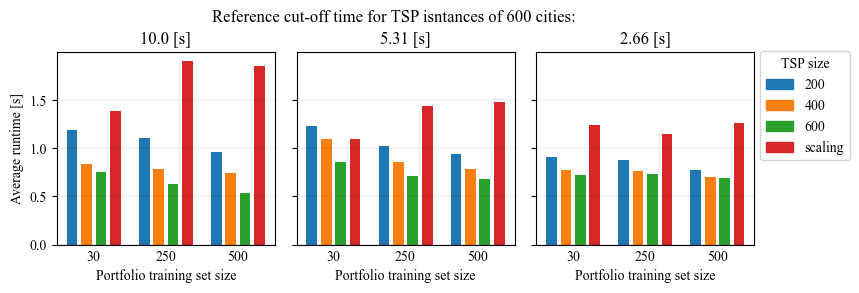

In [119]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

n_to_x = {
    "30": 0,
    "250": 1,
    "500": 2,
}

tsp_size_to_x = {
    "200": 0.0,
    "400": 0.2,
    "600": 0.4,
    "200_400_600": 0.6,
}

label_to_time = {
    "10": "10.0",
    "531": "5.31",
    "266": "2.66",
}

tsp_size_to_color = {
    "200": "C0",
    "400": "C1",
    "600": "C2",
    "200_400_600": "C3",
}

_ = df.groupby(["label", "n", "tsp_size"])["cost_skip_cutoff"].mean().reset_index()
_["x"] = _["n"].map(n_to_x).astype(float) + _["tsp_size"].map(tsp_size_to_x).astype(float)
_["color"] = _["tsp_size"].map(tsp_size_to_color)

fig, axs = plt.subplots(1, 3, figsize=(9, 2.5), sharey=True)
for i, (label, group) in enumerate(_.groupby("label")):
    ax = axs[i]
    ax.bar(group["x"], group["cost_skip_cutoff"], width=0.15, color=group["color"], alpha=1.0)
    ax.set_title(f"{label_to_time[label]} [s]")
    ax.set_xticks([0.3, 1.3, 2.3], labels=["30", "250", "500"])
    ax.tick_params(axis='x', length=0)
    ax.grid(axis='y', color='black', alpha=0.2, lw=0.3, ls="-")
    ax.set_xlabel("Portfolio training set size")

# Create legend
handles = [plt.Rectangle((0,0), 1 , 1, color=tsp_size_to_color[size]) for size in tsp_size_to_color]
labels = ["200", "400", "600", "scaling"]
axs[2].legend(handles, labels, title="TSP size", loc='upper right', bbox_to_anchor=(1.47, 1.04))

axs[0].set_ylabel("Average runtime [s]")
plt.suptitle("Reference cut-off time for TSP isntances of 600 cities:", y=1.05)
plt.subplots_adjust(wspace=0.1)
plt.savefig(BASE_DIR / "cost_skip_cutoff.pdf", bbox_inches='tight')
plt.show()

In [ ]:
# averaged runtime (skip cut-offs) --> ratio to 600

_aggregate("cost_skip_cutoff", ratio=True, format="{:.0%}", axis=None)

\begin{tabular}{lrrrrrrrrrrrr}
label & \multicolumn{4}{r}{10} & \multicolumn{4}{r}{531} & \multicolumn{4}{r}{266} \\
tsp_size & 200 & 400 & 600 & 200_400_600 & 200 & 400 & 600 & 200_400_600 & 200 & 400 & 600 & 200_400_600 \\
n &  &  &  &  &  &  &  &  &  &  &  &  \\
30 & 158% & 110% & 100% & 183% & 143% & 128% & 100% & 127% & 126% & 108% & 100% & 173% \\
250 & 177% & 125% & 100% & 305% & 143% & 120% & 100% & 201% & 120% & 104% & 100% & 157% \\
500 & 180% & 139% & 100% & 346% & 137% & 115% & 100% & 216% & 113% & 102% & 100% & 184% \\
\end{tabular}



In [122]:
# test % cut-offs

_aggregate("test_pct_cutoff", format="{:.1%}")

\begin{tabular}{lrrrrrrrrrrrr}
label & \multicolumn{4}{r}{10} & \multicolumn{4}{r}{531} & \multicolumn{4}{r}{266} \\
tsp_size & 200 & 400 & 600 & 200_400_600 & 200 & 400 & 600 & 200_400_600 & 200 & 400 & 600 & 200_400_600 \\
n &  &  &  &  &  &  &  &  &  &  &  &  \\
30 & 2.2% & 0.7% & 0.6% & 3.4% & 6.7% & 5.2% & 3.3% & 5.4% & 12.0% & 10.7% & 8.8% & 22.8% \\
250 & 2.8% & 0.7% & 0.6% & 4.7% & 5.4% & 4.1% & 2.2% & 9.4% & 12.9% & 8.2% & 8.0% & 23.7% \\
500 & 1.2% & 0.7% & 0.5% & 5.2% & 3.8% & 2.9% & 2.2% & 12.5% & 10.1% & 7.0% & 7.8% & 21.8% \\
\end{tabular}



## TRAIN

In [125]:
# total CPU time

_aggregate("cpu_time", format="{:.2f}", axis=1)

\begin{tabular}{lrrrrrrrrrrrr}
label & \multicolumn{4}{r}{10} & \multicolumn{4}{r}{531} & \multicolumn{4}{r}{266} \\
tsp_size & 200 & 400 & 600 & 200_400_600 & 200 & 400 & 600 & 200_400_600 & 200 & 400 & 600 & 200_400_600 \\
n &  &  &  &  &  &  &  &  &  &  &  &  \\
30 & 0.75 & 3.69 & 9.39 & 4.62 & 0.43 & 2.17 & 5.50 & 2.68 & 0.24 & 1.17 & 2.93 & 1.47 \\
250 & 5.79 & 29.35 & 78.10 & 38.50 & 3.44 & 17.54 & 45.22 & 22.29 & 1.92 & 9.64 & 24.85 & 12.07 \\
500 & 11.61 & 60.10 & 153.99 & 76.70 & 6.72 & 35.28 & 90.02 & 44.83 & 3.90 & 19.08 & 49.43 & 24.32 \\
\end{tabular}



In [94]:
# total CPU time --> ratio to 600

_aggregate("cpu_time", ratio=True, format="{:.1%}", axis=None)

\begin{tabular}{lrrrrrrrrrrrr}
label & \multicolumn{4}{r}{10} & \multicolumn{4}{r}{531} & \multicolumn{4}{r}{266} \\
tsp_size & 200 & 400 & 600 & 200_400_600 & 200 & 400 & 600 & 200_400_600 & 200 & 400 & 600 & 200_400_600 \\
n &  &  &  &  &  &  &  &  &  &  &  &  \\
30 & 8.0% & 39.3% & 100.0% & 49.3% & 7.8% & 39.4% & 100.0% & 48.7% & 8.1% & 40.0% & 100.0% & 50.4% \\
250 & 7.4% & 37.6% & 100.0% & 49.3% & 7.6% & 38.8% & 100.0% & 49.3% & 7.7% & 38.8% & 100.0% & 48.6% \\
500 & 7.5% & 39.0% & 100.0% & 49.8% & 7.5% & 39.2% & 100.0% & 49.8% & 7.9% & 38.6% & 100.0% & 49.2% \\
\end{tabular}



In [97]:
# AVG time no cut-off

_aggregate("train_cost_skip_cutoff", format="{:.2f}", axis=1)

\begin{tabular}{lrrrrrrrrrrrr}
label & \multicolumn{4}{r}{10} & \multicolumn{4}{r}{531} & \multicolumn{4}{r}{266} \\
tsp_size & 200 & 400 & 600 & 200_400_600 & 200 & 400 & 600 & 200_400_600 & 200 & 400 & 600 & 200_400_600 \\
n &  &  &  &  &  &  &  &  &  &  &  &  \\
30 & 0.24 & 1.25 & 3.06 & 1.51 & 0.15 & 0.77 & 1.98 & 0.90 & 0.09 & 0.45 & 1.12 & 0.53 \\
250 & 0.21 & 1.15 & 3.07 & 1.44 & 0.13 & 0.73 & 1.93 & 0.89 & 0.08 & 0.43 & 1.17 & 0.50 \\
500 & 0.22 & 1.18 & 3.01 & 1.42 & 0.13 & 0.72 & 1.90 & 0.89 & 0.08 & 0.42 & 1.15 & 0.51 \\
\end{tabular}



In [99]:
# training % cut-offs

_aggregate("train_pct_cutoff", format="{:.2f}", axis=None)

\begin{tabular}{lrrrrrrrrrrrr}
label & \multicolumn{4}{r}{10} & \multicolumn{4}{r}{531} & \multicolumn{4}{r}{266} \\
tsp_size & 200 & 400 & 600 & 200_400_600 & 200 & 400 & 600 & 200_400_600 & 200 & 400 & 600 & 200_400_600 \\
n &  &  &  &  &  &  &  &  &  &  &  &  \\
30 & 0.55 & 0.60 & 0.64 & 0.61 & 0.61 & 0.68 & 0.73 & 0.69 & 0.72 & 0.76 & 0.79 & 0.79 \\
250 & 0.51 & 0.57 & 0.64 & 0.60 & 0.59 & 0.66 & 0.71 & 0.68 & 0.69 & 0.75 & 0.82 & 0.76 \\
500 & 0.51 & 0.58 & 0.63 & 0.59 & 0.57 & 0.67 & 0.71 & 0.68 & 0.71 & 0.74 & 0.81 & 0.77 \\
\end{tabular}

